In [ ]:
!pip install pandas scikit-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install matplotlib seaborn scikit-learn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader

Load training and testing CSVs

In [ ]:
train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df = pd.read_csv("UNSW_NB15_testing-set.csv")

Optional: Check structure

In [ ]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (175341, 45)
Test shape: (82332, 45)


Drop irrelevant columns

In [ ]:
drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat']
train_df.drop(columns=drop_cols, errors='ignore', inplace=True)
test_df.drop(columns=drop_cols, errors='ignore', inplace=True)

Extract labels

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
X_train = train_df.drop(columns=['label'])
X_test = test_df.drop(columns=['label'])


Normalize features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Convert to PyTorch tensors

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


Create PyTorch Dataloaders

In [ ]:

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# **MLP**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper: Training & Evaluation Function

In [ ]:
def train_model(model, train_loader, test_loader, epochs=50):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


Model A – MLP Classifier

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Initialize and train
input_dim = X_train_tensor.shape[1]
mlp_model = MLPClassifier(input_dim)
train_model(mlp_model, train_loader, test_loader)


Epoch 1/50 - Loss: 206.6707
Epoch 2/50 - Loss: 173.1254
Epoch 3/50 - Loss: 168.4637
Epoch 4/50 - Loss: 165.6520
Epoch 5/50 - Loss: 163.1640
Epoch 6/50 - Loss: 160.8300
Epoch 7/50 - Loss: 158.9678
Epoch 8/50 - Loss: 156.8936
Epoch 9/50 - Loss: 155.5931
Epoch 10/50 - Loss: 153.6124
Epoch 11/50 - Loss: 152.5075
Epoch 12/50 - Loss: 151.2103
Epoch 13/50 - Loss: 150.2912
Epoch 14/50 - Loss: 148.9368
Epoch 15/50 - Loss: 148.5355
Epoch 16/50 - Loss: 147.4756
Epoch 17/50 - Loss: 146.7524
Epoch 18/50 - Loss: 146.2499
Epoch 19/50 - Loss: 145.0322
Epoch 20/50 - Loss: 144.6679
Epoch 21/50 - Loss: 144.2210
Epoch 22/50 - Loss: 143.7303
Epoch 23/50 - Loss: 143.0513
Epoch 24/50 - Loss: 142.8238
Epoch 25/50 - Loss: 141.9368
Epoch 26/50 - Loss: 142.0424
Epoch 27/50 - Loss: 140.8002
Epoch 28/50 - Loss: 140.6167
Epoch 29/50 - Loss: 140.3502
Epoch 30/50 - Loss: 140.0113
Epoch 31/50 - Loss: 139.1989
Epoch 32/50 - Loss: 139.3513
Epoch 33/50 - Loss: 138.6491
Epoch 34/50 - Loss: 138.5718
Epoch 35/50 - Loss: 138

Model B – 1D ResNet Classifier

In [ ]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(ResNet1D, self).__init__()
        self.input_size = input_size
        self.layer1 = BasicBlock1D(1, 32)
        self.layer2 = BasicBlock1D(32, 64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, self.input_size)  # reshape for Conv1d
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x).squeeze(2)
        return self.fc(x)

# Initialize and train
resnet_model = ResNet1D(input_dim)
train_model(resnet_model, train_loader, test_loader)


Epoch 1/50 - Loss: 218.3715
Epoch 2/50 - Loss: 178.5709
Epoch 3/50 - Loss: 171.4774
Epoch 4/50 - Loss: 168.1370
Epoch 5/50 - Loss: 165.3877
Epoch 6/50 - Loss: 163.5329
Epoch 7/50 - Loss: 161.3497
Epoch 8/50 - Loss: 159.7078
Epoch 9/50 - Loss: 158.8957
Epoch 10/50 - Loss: 157.9178
Epoch 11/50 - Loss: 156.9253
Epoch 12/50 - Loss: 155.9021
Epoch 13/50 - Loss: 154.9681
Epoch 14/50 - Loss: 154.4951
Epoch 15/50 - Loss: 153.3046
Epoch 16/50 - Loss: 153.3669
Epoch 17/50 - Loss: 152.1241
Epoch 18/50 - Loss: 152.0085
Epoch 19/50 - Loss: 151.2585
Epoch 20/50 - Loss: 150.7180
Epoch 21/50 - Loss: 150.4082
Epoch 22/50 - Loss: 150.1733
Epoch 23/50 - Loss: 150.0001
Epoch 24/50 - Loss: 149.2396
Epoch 25/50 - Loss: 148.8370
Epoch 26/50 - Loss: 148.3897
Epoch 27/50 - Loss: 147.7158
Epoch 28/50 - Loss: 147.9494
Epoch 29/50 - Loss: 147.1832
Epoch 30/50 - Loss: 147.0868
Epoch 31/50 - Loss: 146.8352
Epoch 32/50 - Loss: 146.1123
Epoch 33/50 - Loss: 145.7676
Epoch 34/50 - Loss: 145.6011
Epoch 35/50 - Loss: 145

Compare Performance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

def evaluate_and_visualize(model, dataloader, model_name="Model"):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1)
            pred = torch.argmax(probs, dim=1).cpu().numpy()

            y_true.extend(yb.numpy())
            y_pred.extend(pred)
            y_probs.extend(probs[:, 1].cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


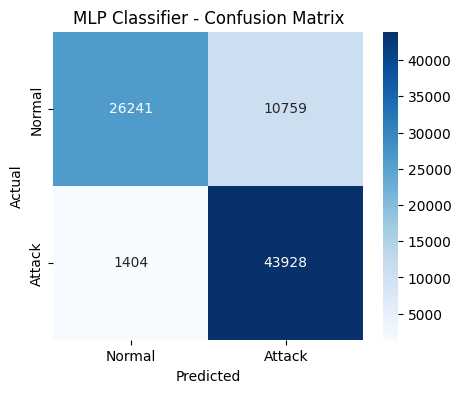


MLP Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     37000
           1       0.80      0.97      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.88      0.84      0.85     82332
weighted avg       0.87      0.85      0.85     82332



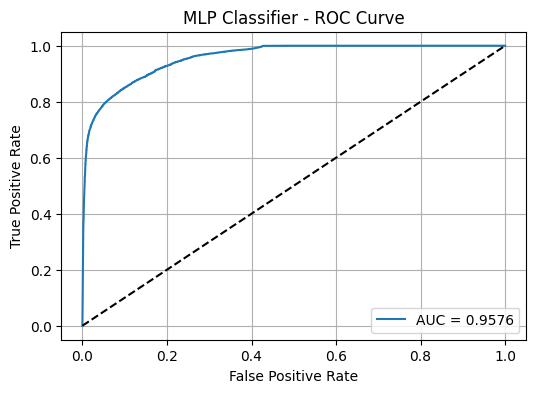

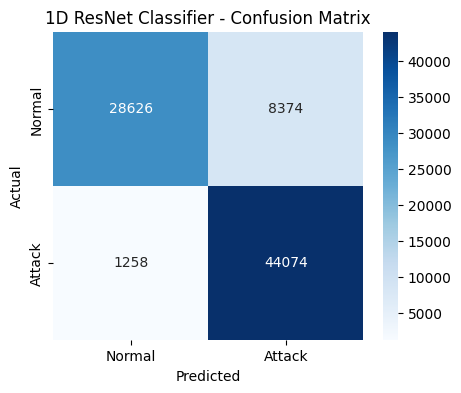


1D ResNet Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86     37000
           1       0.84      0.97      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.90      0.87      0.88     82332
weighted avg       0.89      0.88      0.88     82332



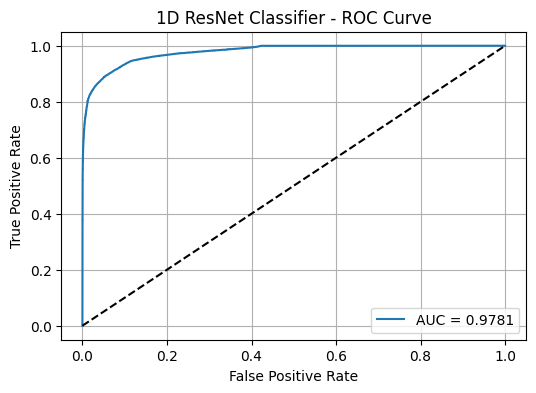

In [ ]:
evaluate_and_visualize(mlp_model, test_loader, model_name="MLP Classifier")
evaluate_and_visualize(resnet_model, test_loader, model_name="1D ResNet Classifier")


Add Spatial Attention to ResNet1D

In [ ]:
import torch.nn as nn
import torch
class SpatialAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention1D, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        combined = torch.cat((avg_pool, max_pool), dim=1)
        attn = self.sigmoid(self.conv(combined))
        return x * attn  # element-wise multiplication


In [ ]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)


In [ ]:
class SAResNet1D(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(SAResNet1D, self).__init__()
        self.input_size = input_size

        self.block1 = BasicBlock1D(1, 32)
        self.block2 = BasicBlock1D(32, 64)
        self.block3 = BasicBlock1D(64, 128)

        self.sa = SpatialAttention1D(kernel_size=7)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, self.input_size)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.sa(x)
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        return self.fc(x)


In [ ]:
sa_resnet = SAResNet1D(input_dim).to(device)
train_model(sa_resnet, train_loader, test_loader, epochs=50)


Epoch 1/50 - Loss: 197.7571
Epoch 2/50 - Loss: 168.1998
Epoch 3/50 - Loss: 162.8101
Epoch 4/50 - Loss: 159.8587
Epoch 5/50 - Loss: 157.0587
Epoch 6/50 - Loss: 154.8210
Epoch 7/50 - Loss: 152.4905
Epoch 8/50 - Loss: 150.9781
Epoch 9/50 - Loss: 149.9003
Epoch 10/50 - Loss: 148.1450
Epoch 11/50 - Loss: 147.3064
Epoch 12/50 - Loss: 146.0842
Epoch 13/50 - Loss: 144.9429
Epoch 14/50 - Loss: 143.5229
Epoch 15/50 - Loss: 143.0839
Epoch 16/50 - Loss: 141.3989
Epoch 17/50 - Loss: 141.0397
Epoch 18/50 - Loss: 139.7254
Epoch 19/50 - Loss: 139.0541
Epoch 20/50 - Loss: 137.9117
Epoch 21/50 - Loss: 137.3162
Epoch 22/50 - Loss: 136.0229
Epoch 23/50 - Loss: 135.1952
Epoch 24/50 - Loss: 134.7281
Epoch 25/50 - Loss: 133.7367
Epoch 26/50 - Loss: 133.2549
Epoch 27/50 - Loss: 132.6378
Epoch 28/50 - Loss: 131.3752
Epoch 29/50 - Loss: 130.3246
Epoch 30/50 - Loss: 129.2966
Epoch 31/50 - Loss: 128.4336
Epoch 32/50 - Loss: 127.8826
Epoch 33/50 - Loss: 127.0407
Epoch 34/50 - Loss: 126.2865
Epoch 35/50 - Loss: 125

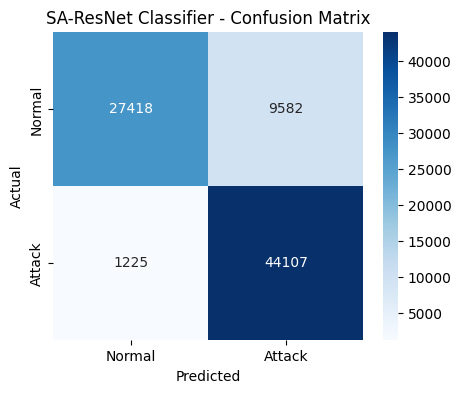


SA-ResNet Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     37000
           1       0.82      0.97      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.88      0.87      0.87     82332



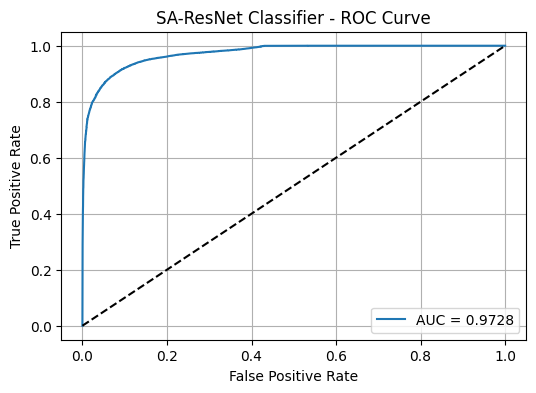

In [ ]:
evaluate_and_visualize(sa_resnet, test_loader, model_name="SA-ResNet Classifier")

Evaluate on different threshold


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import matplotlib.pyplot as plt

def evaluate_with_thresholds(model, dataloader, model_name="Model", thresholds=np.arange(0.1, 1.0, 0.1)):
    model.eval()
    device = next(model.parameters()).device

    y_true = []
    y_probs = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)

            # Handle binary classification with sigmoid
            if logits.shape[1] == 1 or len(logits.shape) == 1:
                probs = torch.sigmoid(logits).view(-1)
            else:
                probs = torch.softmax(logits, dim=1)[:, 1]

            if yb.ndim > 1 and yb.shape[1] > 1:
                yb = torch.argmax(yb, dim=1)

            y_true.extend(yb.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)

    # Store metrics
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    print(f"\n{model_name} - Threshold Tuning (0.1 to 0.9):")
    print("Threshold  Accuracy   Precision  Recall     F1-Score")
    print("------------------------------------------------------")

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"{threshold:8.2f}  {accuracy:10.4f}  {precision:10.4f}  {recall:10.4f}  {f1:10.4f}")

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    # 📊 Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, recalls, label='Recall', marker='^')
    plt.plot(thresholds, f1s, label='F1 Score', marker='d')

    plt.title(f"{model_name} Metrics vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.xticks(thresholds)
    plt.tight_layout()
    plt.show()



SA-ResNet Classifier - Threshold Tuning (0.1 to 0.9):
Threshold  Accuracy   Precision  Recall     F1-Score
------------------------------------------------------
    0.10      0.8144      0.7504      0.9933      0.8549
    0.20      0.8230      0.7615      0.9882      0.8601
    0.30      0.8351      0.7765      0.9836      0.8678
    0.40      0.8505      0.7963      0.9789      0.8782
    0.50      0.8687      0.8215      0.9730      0.8909
    0.60      0.8848      0.8471      0.9649      0.9022
    0.70      0.8977      0.8716      0.9549      0.9114
    0.80      0.9074      0.8953      0.9419      0.9180
    0.90      0.9111      0.9202      0.9181      0.9192


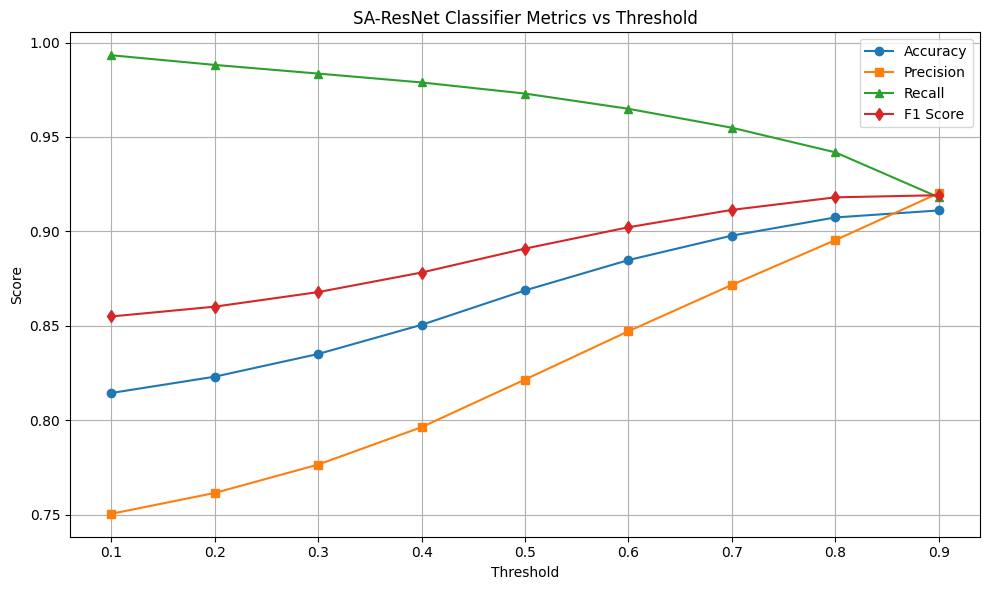

In [ ]:
evaluate_with_thresholds(sa_resnet, test_loader, model_name="SA-ResNet Classifier")


1D ResNet Classifier - Threshold Tuning (0.1 to 0.9):
Threshold  Accuracy   Precision  Recall     F1-Score
------------------------------------------------------
    0.10      0.8108      0.7450      0.9978      0.8531
    0.20      0.8158      0.7515      0.9941      0.8560
    0.30      0.8314      0.7702      0.9889      0.8659
    0.40      0.8565      0.8022      0.9813      0.8827
    0.50      0.8830      0.8403      0.9722      0.9015
    0.60      0.9023      0.8738      0.9615      0.9155
    0.70      0.9165      0.9049      0.9480      0.9259
    0.80      0.9178      0.9292      0.9209      0.9250
    0.90      0.9097      0.9669      0.8656      0.9134


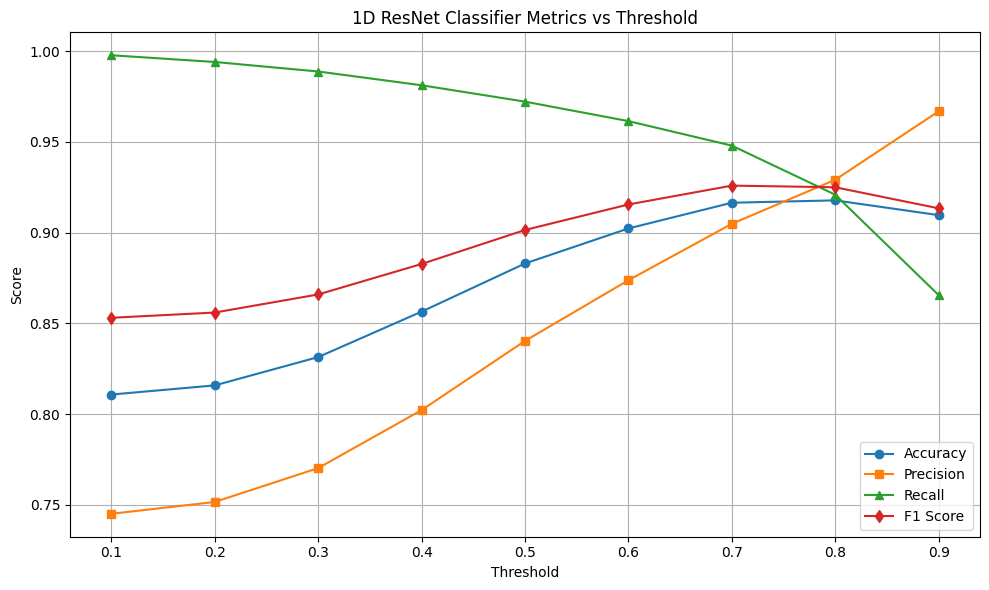

In [ ]:
evaluate_with_thresholds(resnet_model, test_loader, model_name="1D ResNet Classifier")


MLP Classifier - Threshold Tuning (0.1 to 0.9):
Threshold  Accuracy   Precision  Recall     F1-Score
------------------------------------------------------
    0.10      0.8078      0.7427      0.9960      0.8509
    0.20      0.8103      0.7463      0.9929      0.8521
    0.30      0.8159      0.7540      0.9881      0.8553
    0.40      0.8339      0.7765      0.9807      0.8667
    0.50      0.8523      0.8033      0.9690      0.8784
    0.60      0.8655      0.8301      0.9503      0.8861
    0.70      0.8717      0.8554      0.9230      0.8879
    0.80      0.8739      0.8878      0.8826      0.8852
    0.90      0.8693      0.9257      0.8293      0.8748


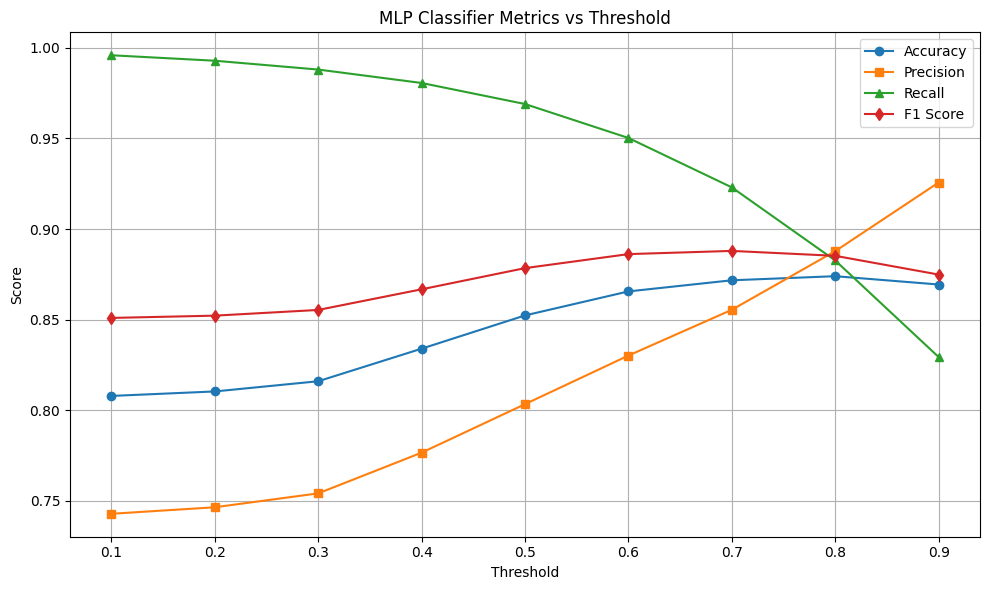

In [ ]:
evaluate_with_thresholds(mlp_model, test_loader, model_name="MLP Classifier")